In [2]:
#ignore
%pylab inline
%load_ext rpy2.ipython
%config InlineBackend.figure_format='retina'
from SuchTree import SuchTree, SuchLinkedTrees
import pandas
import seaborn
import matplotlib

from rpy2 import robjects

# tell R to be quiet
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings( 'ignore', category=RRuntimeWarning )
robjects.r( 'options( warn = -1 )' )
robjects.r( 'sink( "/dev/null" )' )

# load libraries into the R global context
robjects.r( 'library("phytools")' )
robjects.r( 'library("igraph")' )

Populating the interactive namespace from numpy and matplotlib


/home/russell/opt/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


array(['igraph', 'phytools', 'maps', 'ape', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='|S9')

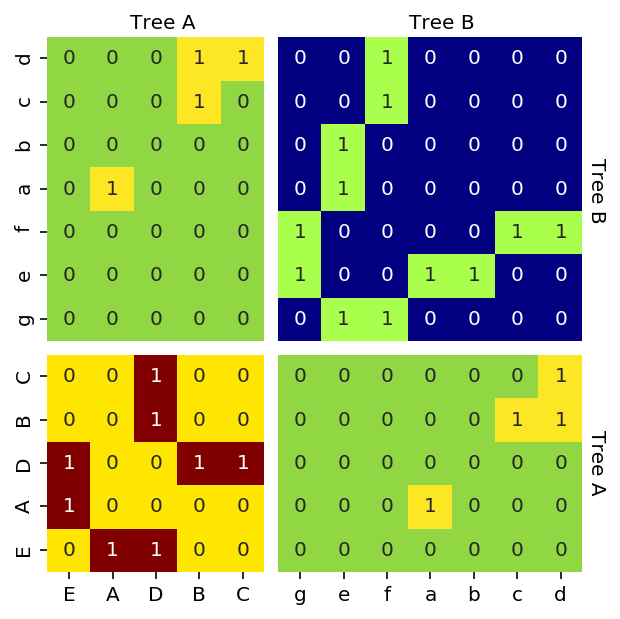

In [6]:
from dendropy import Tree

def tree_labels( treefile ) :
    t = Tree.get( file=open(treefile), schema='newick' )
    labels = []
    for node in t.inorder_node_iter() :
        if node.label :
            labels.append( node.label )
        else :
            labels.append( node.taxon.label )
    return labels

with open( '/tmp/tiny_tree_A.tree', 'w' ) as f :
    #f.write( '(A:1,(B:1,(C:1,D:1)E:1)F:1)G:1;' )
    f.write( '(A:2,(B:1,C:1)D:1)E:1;' )
    
with open( '/tmp/tiny_tree_B.tree', 'w' ) as f :
    f.write( '((a:1,b:1)e:1,(c:1,d:1)f:1)g:1;' )

T1 = SuchTree( '/tmp/tiny_tree_A.tree' )
t1_labels = tree_labels( '/tmp/tiny_tree_A.tree' )
t1_labels = [ t1_labels[i] for i in T1.adjacency()['node_ids'] ]

T2 = SuchTree( '/tmp/tiny_tree_B.tree' )
t2_labels = tree_labels( '/tmp/tiny_tree_B.tree' )
t2_labels = [ t2_labels[i] for i in T2.adjacency()['node_ids'] ]


links = pandas.DataFrame( zeros( (3,4), dtype=int ), index=T1.leafs.keys(), columns=T2.leafs.keys() )

for i,j in ( ('A','a'), ('B','c'), ('B','d'), ('C','d'), ('C','d') ) :
    links.at[i,j] = 1

links.to_csv( '/tmp/tiny_tree_links.csv' )

SLT = SuchLinkedTrees( T1, T2, links )

adj = pandas.DataFrame( numpy.ceil( SLT.adjacency() ), dtype=int, 
                        index=t1_labels+t2_labels,
                        columns=t1_labels+t2_labels)

figure( figsize=(4,4) )

gs = matplotlib.gridspec.GridSpec( 2, 2,
                                   width_ratios=[5, 7],
                                   height_ratios=[7,5], )

subplot( gs[0,0] )
ax3 = seaborn.heatmap( adj[ t1_labels ].loc[ t2_labels ],
                       cbar=False, square=True, annot=True,
                       xticklabels=False, yticklabels=True,
                       center=-2, cmap='viridis' )
ax3.invert_yaxis()

subplot( gs[0,1] )
ax2 = seaborn.heatmap( adj[ t2_labels ].loc[ t2_labels ],
                       cbar=False, square=True, annot=True,
                       xticklabels=False, yticklabels=False,
                       center=0.9, cmap='jet' )
ax2.invert_yaxis()
text( 7.1, -2.4, 'Tree A', rotation=-90 )

subplot( gs[1,0] )
ax1 = seaborn.heatmap( adj[ t1_labels ].loc[ t1_labels ], 
                       cbar=False, square=True, annot=True,
                       xticklabels=True, yticklabels=True,
                       center=-0.5, cmap='jet' )
ax1.invert_yaxis()
text( 1.9, 12.5, 'Tree A' )


subplot( gs[1,1] )
ax4 = seaborn.heatmap( adj[ t2_labels ].loc[ t1_labels ],
                       cbar=False, square=True, annot=True,
                       xticklabels=True, yticklabels=False,
                       center=-2, cmap='viridis' )
ax4.invert_yaxis()
text( 3.0, 12.5, 'Tree B' )
text( 7.1, 9.2,   'Tree B', rotation=-90 )

gs.tight_layout(gcf(), pad=0, w_pad=0 )
savefig( 'figures/tiny_tree_adjacency.svg' )
#savefig( 'figures/tiny_tree_adjacency.pdf' )

In [7]:
%%R

#ignore

tr1 <- read.tree( "/tmp/tiny_tree_A.tree" )
tr2 <- read.tree( "/tmp/tiny_tree_B.tree" )
links <- read.csv( "/tmp/tiny_tree_links.csv", row.names=1, stringsAsFactors = F )
im <- graph_from_incidence_matrix( as.matrix( links ) )
assoc <- as_edgelist( im )
obj <- cophylo( tr1, tr2, assoc=assoc )
svg( "figures/tiny_tree_cophylo.svg", width = 4, height = 4 )
pdf( "figures/tiny_tree_cophylo.pdf", width = 4, height = 4 )
plot( obj )
dev.off()

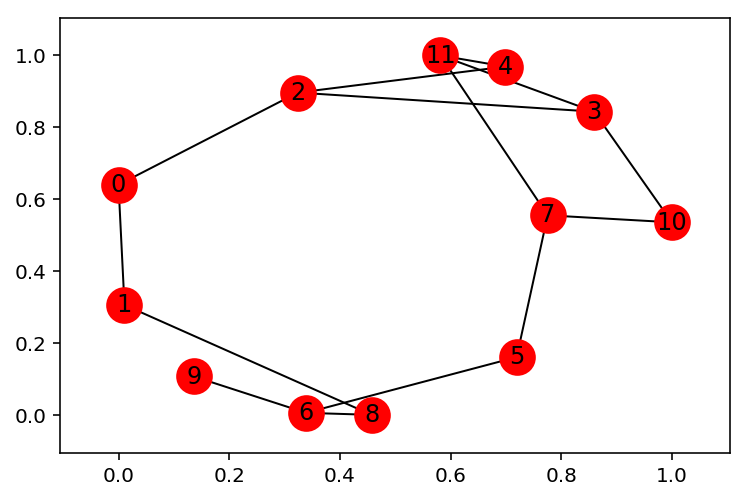

In [101]:
import networkx as nx

g = nx.from_numpy_matrix(SLT.adjacency())
#fig, ax = plt.subplots(1, 1, figsize=(8, 6));
nx.draw_networkx(g)
nx.draw_networkx?

Microbiome data yields two types of information. The sequences themselves shed light on relationships among organisms in through time, and the distributions and frequencies of those sequences on relationships among organisms across space. Evolutionary relationships tells us about what happened over deep time, and ecological relationships tell us about what was happening at the moment the samples were collected. There are many ways structure and interpret this information, and each carries an implicit opinion about what properties of these relationships are important.

One way to structure this information to build phylogenetic trees for each group of organisms involved in the interaction, and note which organisms at the tips of these trees were observed to interact with which other organisms. This model is called a co-phylogeny, and pops up in the literature whenever the evolution of two things is somehow linked together. [[1]](#1) For example, phylogenomics addresses the implications of the fact that genes within the same genome have unique, individual evolutionary histories. Trees representing the evolution of homologous genes can be linked by the genomes in which the homologs co-occur, or they can be linked to trees representing the evolution of the species. Alternatively, the two trees can represent two very different groups of species that interact ecologically, such a group of host organisms and their parasites.

Co-phylogenies exist on a continuum of intimacy. At one extreme, different regions of a single gene could evolve under somewhat different selective pressures. For example, the evolution of an catalytic domain and a signaling domain of a protein could be examined by building trees for the two domains and linking them through each allele. At the other extreme, the evolution of two groups of species that do not interact may fall under a common influence. For example, penguins and flowering plants probably did not strongly influence each other's evolution, but parallels in their co-phylogeny indicate that the evolution of both was influenced by the breakup the [Gondwanan super-continent](https://en.wikipedia.org/wiki/Gondwana#Biogeography). 

* domains within the same gene (domain-tree:domain-tree)
* domains of a protein verses the whole protein 
* alleles of different genes (phylogenomics)
* alleles of a gene verses the species (speciation)
* nuclear verses mitochondrial or chloroplast genes (endosymbiosis)
* host verses parasite (antagonistic coevolution)
* host verses symbiont (mutualistic coevolution)
* interacting species (comensal coevolution)
* co-distributed species (biogeography, parallel evolution)
* propinquity (association without coevolution)

Co-phylogenies built from microbiome data represent a mixture of the last six categories. This is a substantial theoretical challenge. Most models for coevolution are designed to explore carefully framed interactions. Just as human beings in large social networks are often only vaugely aware of the emergent cliques to which they belong, microbiome data does not come with neatly curated host-microbe interactions. The salient features embedded in the graph must somehow be described, detected and extracted.

So, practically speaking, how does one go about building this representation? The first step is to build an [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix). The adjacency matrix of a graph of $n$ nodes is an $n \times n$ matrix. Connections between nodes ("edges," in graph jargon) are represented as 1's in the row and column for the two nodes. Because there is a row and a column for each node, there are two ways places to mark a connection. If you imagine connections as going _from_ the column node _to_ the row node, you can have connections with a direction. Directed graphs are useful when the nodes represent things that can be connected asymmetrically. Social networks are like this; Alice might say that she is friends with Bob, but Bob might not reciprocate because he forgot his password (we all know that [Alice and Bob are friends in real life](https://en.wikipedia.org/wiki/Alice_and_Bob)). 

<style>
.rendered_html td.p { text-align: left !important; }
.rendered_html td, tr, table, img, .rendered_html img.unconfined, div.text_cell { vertical-align: middle !important; }
</style>
<table>
<tr>
    <td> <div><img src="figures/little_tree.svg" width=250x250></div> </td>
    <td> <div vertical-align="top">$$\begin{array}{c|cccccc}
           & \mathbf{a} & \mathbf{b} & \mathbf{c} & \mathbf{d} & \mathbf{e} & \mathbf{f} & \mathbf{g} \cr \hline
\mathbf{a} & \ddots     & \alpha     & \delta     & 0          & 0          & 0          & 0          \cr
\mathbf{b} & \alpha     & \ddots     & 0          & \beta      & \gamma     & 0          & 0          \cr
\mathbf{c} & \delta     & 0          & \ddots     & 0          & 0          & \epsilon   & \zeta      \cr
\mathbf{d} & 0          & \beta      & 0          & \ddots     & 0          & 0          & 0          \cr
\mathbf{e} & 0          & \gamma     & 0          & 0          & \ddots     & 0          & 0          \cr
\mathbf{f} & 0          & 0          & \epsilon   & 0          & 0          & \ddots     & 0          \cr
\mathbf{g} & 0          & 0          & \zeta      & 0          & 0          & 0          & \ddots     \cr
\end{array}$$</div>
    </td>
</tr>
<tr>
    <td colspan="2">
        <p><b>Figure 2 :</b> Construction of the weighted graph adjacency matrix of a tree.</p>
    </td>
</tr>
</table>

Our nodes represent leafs and junctions of phylogenetic trees, and our edges represent either phylogenetic distance between tree junctions or ecological connections between leafs. It's not obvious what "direction" would mean for that kind of object, and so we're not going to use a directed graph. Undirected graphs can be represented either by a symmetric adjacency matrix ($A_{i,j} \equiv A_{j,i}$), or by a triangular half-matrix. I hate looking at plots of triangular matrixes, so I'm always going to draw them with top and bottom triangles. This is redundant information that we might want to discard later for faster performance, but for now we'll use it to make the plots easier to understand.

Adjacency matrixes can have connections from a node back to itself. These go along the diagonal ($A_{i,i}$). In a directed graph, it doesn't matter which direction a self-connected edge is oriented, so it makes sense that they don't have a doppelganger in the other triangle of the adjacency matrix. Or, they are their own doppelganger, if you prefer to think of it that way. For our purposes, self-connected nodes don't make any sense. We will disallow them by requiring that $A_{i,i} \equiv 0$.

So far, we've only included information about {\em whether or not} two nodes are connected, and so edges are represented as either 0 or 1. Instead of representing a social network with a binary value (Alice is friends with Bob, but not with Mallory), we might represent it with a continuous quantity (Alice has sent Bob 14.3 gigabytes of cat videos). When we put those quantities into the adjacency matrix, the graph jargon for this is a {\em weighted} adjacency matrix. In Figure 2, you can see how this works for a small tree. 

We have two types of information we want to include in our graph; phylogenetic branch length and ecological associations. Figure 2 only shows branch lengths for a single tree. How do we get all of that into an adjacency matrix? Hold onto your hats, folks, because this is the one truly original idea from my Ph.D. Ready? OK. Here it goes.

All the nodes belong to either one tree or the other. So you take the adjacency matrixes for the two trees and just... stick them together. Yep. That's it.

Graphs are absurdly flexible objects. They have the kind of omnivorous generality of a relational database, minus the need to actually _understand_ your data. They are the perfect receptacle for mysterious, complicated stuff. So, you can represent a tree as a graph, as we've already done. Or, you can represent two trees. Graphs don't have to be fully connected, so we haven't broken any rules by pasting two graphs together. You just stick the adjacency matrixes together along their diagonals.

<style>
.rendered_html td.p { text-align: left !important; }
</style>
<table>
<tr>
    <td> <img src="figures/tiny_tree_cophylo.svg" width=280x280> </td>
    <td> <img src="figures/tiny_tree_adjacency.svg" width=280x280> </td>
</tr>
<tr>
    <td colspan="2">
        <p><b>Figure 3 :</b> Construction of the graph adjacency matrix of a cophylogeny. For clarity, this example shows a adjacency matrix without edge weights, node labels or edge labels.</p>
    </td>
</tr>
</table>

In the co-phylogeny, the leafs are connected by ecological data. For a host-parasite interaction, the leaf nodes are connected by the host range of the parasites. For a phylogenomics problem, the leaf nodes represent alleles that are linked by the genomes where they are found together. For microbiome data, the leaf nodes represent the sampled hosts and observed OTUs that are linked by the read count table. To express those links, you just find the row and column that correspond to the two leafs, and you put the quantity in that element.

Because the two trees are not connected by phylogenetic links, there are two empty blocks in the combined adjacency matrix above and below the diagonal. That is where the ecological links go. Because adjacency matrixes are all-by-all, the blocks representing each of the trees will be square, and so will the combined adjacency matrix. If the two trees aren't the same size, though, the blocks where the ecological links go will be rectangular. Figure 3 illustrates what this looks like.

There is one final consideration -- normalization. Unless you are lucky enough to have time calibrated trees, the branch lengths of the trees are probably in different scales. The ecological observations are a totally different category of information. So, what to do?

As we'll see in following posts, we are building this graph so that we can compare it to other graphs representing co-phylogenies of other events. There are myriad reasons why events with similar ecological and evolutionary dynamics might happen over vastly different scales -- the generation time of the organisms involved, or the substitution rates of the marker genes used, or the population sizes... Suffice it to say that it makes the most sense to treat units of phylogenetic branch length in relative terms, and normalize the root-to-deepest-tip for all trees to 1.

To keep the ecological observations in scope, I have made the somewhat arbitrary choice to normalize them to be bounded by the longest and shortest branches found in the two trees. If they are presence-absence observations, then they receive edge weights equal to the average branch length found in the normalized trees. 

In the next section, we will look at some relatively simple things we can do by representing co-phylogenies as graphs.

### Further Reading

* [A gentle introduction to graph theory](https://medium.com/basecs/a-gentle-introduction-to-graph-theory-77969829ead8), by Vaidehi Joshi
* 

### Footnotes

#### [1]
It is important to note that a co-phylogeny contains an implicit opinion that relationships that are "important" now were "important" in the past, and as such, may have influenced the evolution of the organisms in involved. Exactly what is meant by "important" depends on what the trees represent and on the calculations are performed on the co-phylogeny, but it should be acknowledged that simply arranging the data this way is not a neutral choice. There are other valid ways to think about this information.